In [197]:
# From https://archive.ics.uci.edu/ml/datasets/DrivFace#

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('drivPoints.txt')
df.head(3)

,fileName,subject,imgNum,label,ang,xF,yF,wF,hF,xRE,yRE,xLE,yLE,xN,yN,xRM,yRM,xLM,yLM
0,20130529_01_Driv_001_f,1,1,2,0,292,209,100,112,323,232,367,231,353,254,332,278,361,278
1,20130529_01_Driv_002_f,1,2,2,0,286,200,109,128,324,235,366,235,353,258,333,281,361,281
2,20130529_01_Driv_003_f,1,3,2,0,290,204,105,121,325,240,367,239,351,260,334,282,362,282


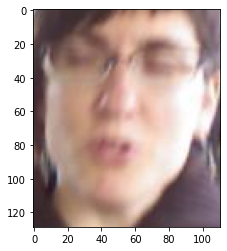

In [3]:
img_data = df.iloc[25]
img = plt.imread('DrivImages/'+ img_data.fileName + '.jpg')
plt.imshow(img[img_data.yF : img_data.yF+img_data.hF, img_data.xF : img_data.xF+img_data.wF]);

In [4]:
def generate_u0(c,n):
    u0= []
    for i in range(c):
        u0.append([])
        for j in range(n):
            if i==j or i==j%c:
                u0[i].append(1)
            else:
                u0[i].append(0)
    return u0

In [5]:
def generate_vt(u, x, c, n, p, m):
    v=[]
    for i in range(c):
        v.append([])
        for j in range(p):
            v_ij=sum((u[i][k]**m)*x[k][j] for k in range(n))/sum(u[i][k]**m for k in range(n))
            v[i].append(v_ij)
    return v

In [6]:
def calculate_d(x,v, c, n):
    d=[]
    for i in range(c):
        d.append([])
        for k in range(n):           
            d[i].append(np.linalg.norm(abs(np.subtract(x[k],v[i]))))
    return d

In [7]:
def generate_u(d, m, c, n):
    d_eps = 1e-6
    u=[]
    for i in range(c):
        u.append([])
        for k in range(n):
            u_sum=0
            different=False
            for s in range(c):
                if d[s][k]==0:
                    d[s][k] += d_eps
                #     different=True
                #     break
                u_sum+=(d[i][k]/d[s][k])**(2/(m-1))
            if not different:
                u[i].append(1/u_sum)                  
    return u

In [8]:
def delta_u(u1, u2, c, n):
    return sum(sum(np.linalg.norm(np.subtract(u2[i][k], u1[i][k])) for k in range(n)) for i in range(c))

In [9]:
X = df[['xF','yF','wF','hF', 'xRE', 'yRE', 'xLE', 'yLE', 'xN', 'yN', 'xRM', 'yRM', 'xLM', 'yLM']].values
# X = df[['xRE', 'yRE', 'xLE', 'yLE', 'xN', 'yN', 'xRM', 'yRM', 'xLM', 'yLM']].values

In [10]:
p=X.shape[1]
n=X.shape[0]
c=3
m=2
epsilon = 1e-5
d_u = 2*epsilon
u_old=generate_u0(c,n)
print(p,n)

14 606


In [11]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,init='random').fit_transform(X)

In [12]:
import seaborn as sns
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = X_embedded[:,0]
df_tsne['tsne-2d-two'] = X_embedded[:,1]
df_tsne['y'] = df['label'].values

In [13]:
df_tsne

,tsne-2d-one,tsne-2d-two,y
0,3.248867,-3.153574,2
1,4.550729,-3.072747,2
2,4.609246,-3.315497,2
3,1.896472,-2.487545,2
4,0.942975,-1.374582,2
...,...,...,...
601,17.838182,12.382758,2
602,18.565414,11.159802,1
603,19.078083,10.724272,1
604,19.908421,12.909052,2


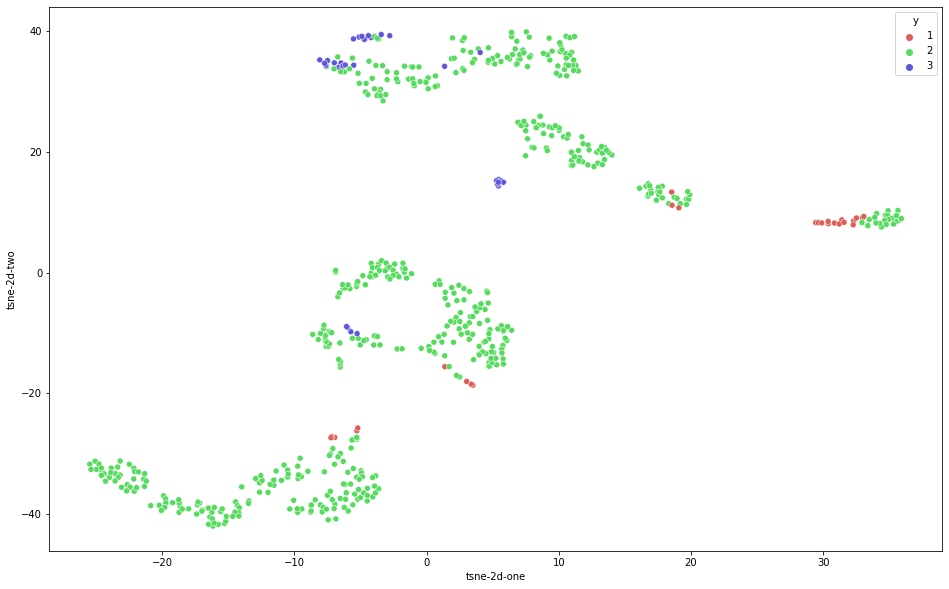

In [14]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 3),
    data=df_tsne,
    legend="full"
);

In [15]:
while epsilon<d_u:
    v = generate_vt(u_old,X,c,n,p,m)
    d = calculate_d(X,v,c,n)
    u_new = generate_u(d, m, c, n)
    d_u = delta_u(u_old, u_new, c, n)
    u_old = u_new
    print(d_u)

807.9905507944912
7.564678683909661
18.69972316250808
46.016837181272706
103.60907330119824
159.00741219871136
136.1470018749603
171.62010495203947
100.93638397695376
24.595877653213996
9.50734287505712
4.435603425812131
2.1340430808028272
1.0355117718687281
0.5042962867107613
0.24597616393786803
0.12006230659757003
0.05861950074350526
0.0286234966176131
0.013977071339560339
0.00682512800836554
0.003332750916016324
0.0016273906656851297
0.00079465419922689
0.00038802760986716457
0.000189472313583701
9.251837834518535e-05
4.5176203231642956e-05
2.2059266588459045e-05
1.0771400968288651e-05
5.259602118599959e-06


In [16]:
unique, counts = np.unique(np.array(u_new).argmax(axis=0), return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 233],
       [  1, 168],
       [  2, 205]])

In [17]:
unique, counts = np.unique(df.label.values-1, return_counts=True)
np.asarray((unique, counts)).T

array([[  0,  27],
       [  1, 546],
       [  2,  33]])

In [62]:
from scipy.spatial.distance import pdist, squareform

norm_df = df[['xF','yF','wF','hF', 'xRE', 'yRE', 'xLE', 'yLE', 'xN', 'yN', 'xRM', 'yRM', 'xLM', 'yLM']]
norm_df=(norm_df-norm_df.min())/(norm_df.max()-norm_df.min())
distances = pdist(norm_df.values, metric='minkowski', p=norm_df.shape[1])
dist_matrix = squareform(distances)
q_0 = 1 - dist_matrix / dist_matrix.max()
q_0

array([[1.        , 0.68429928, 0.82241838, ..., 0.5673752 , 0.31791863,
        0.34714197],
       [0.68429928, 1.        , 0.8618809 , ..., 0.70263343, 0.46091316,
        0.492623  ],
       [0.82241838, 0.8618809 , 1.        , ..., 0.65008458, 0.39748915,
        0.42914827],
       ...,
       [0.5673752 , 0.70263343, 0.65008458, ..., 1.        , 0.74631162,
        0.77567499],
       [0.31791863, 0.46091316, 0.39748915, ..., 0.74631162, 1.        ,
        0.91480604],
       [0.34714197, 0.492623  , 0.42914827, ..., 0.77567499, 0.91480604,
        1.        ]])

In [70]:
my_array = np.array([ [1, 1, 1], [3, 3, 3] ])
pdist(my_array, metric='minkowski', p=3)

array([2.88449914])

In [71]:
2**3*3, 2.88449914**3

(24, 23.999999984653556)

In [69]:
(2**3*3)**(1/3)

2.8844991406148166